
# Harmonic-percussive source separation

This notebook illustrates how to separate an audio signal into
its harmonic and percussive components.

We'll compare the original median-filtering based approach of
[Fitzgerald, 2010](https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1078&context=argcon)
and its margin-based extension due to [Dreidger, Mueller and Disch, 2014](https://zenodo.org/record/1415226).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

import librosa

Load an example clip with harmonics and percussives



In [2]:
y, sr = librosa.load(librosa.ex('fishin'), duration=5, offset=10)

Audio(data=y, rate=sr)

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Compute the short-time Fourier transform of y



In [3]:
D = librosa.stft(y)

In [5]:
D.shape

(1025, 216)

Decompose D into harmonic and percussive components

$D = D_\text{harmonic} + D_\text{percussive}$



In [4]:
D_harmonic, D_percussive = librosa.decompose.hpss(D)

We can plot the two components along with the original spectrogram



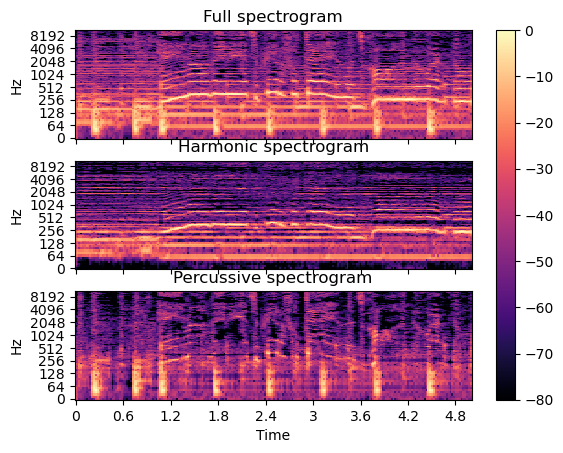

In [6]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full spectrogram')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Harmonic spectrogram')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Percussive spectrogram')
fig.colorbar(img, ax=ax)

We can also invert the separated spectrograms to play back the audio.
First the harmonic signal:



In [9]:
y_harmonic = librosa.istft(D_harmonic, length=len(y))
Audio(data=y_harmonic, rate=sr)

And next the percussive signal:



In [8]:
y_percussive = librosa.istft(D_percussive, length=len(y))
Audio(data=y_percussive, rate=sr)

The default HPSS above assigns energy to each time-frequency bin according to
whether a horizontal (harmonic) or vertical (percussive) filter responds higher
at that position.

This assumes that all energy belongs to either a harmonic or percussive source,
but does not handle "noise" well.  Noise energy ends up getting spread between
D_harmonic and D_percussive.  Unfortunately, this often also includes vocals
and other sounds that are not purely harmonic or percussive.

If we instead require that the horizontal filter responds more than the vertical
filter *by at least some margin*, and vice versa, then noise can be removed
from both components.

Note: the default (above) corresponds to margin=1



In [10]:
# Let's compute separations for a few different margins and compare the results below
D_harmonic2, D_percussive2 = librosa.decompose.hpss(D, margin=2)
D_harmonic4, D_percussive4 = librosa.decompose.hpss(D, margin=4)
D_harmonic8, D_percussive8 = librosa.decompose.hpss(D, margin=8)
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

In the plots below, note that vibrato has been suppressed from the harmonic
components, and vocals have been suppressed in the percussive components.



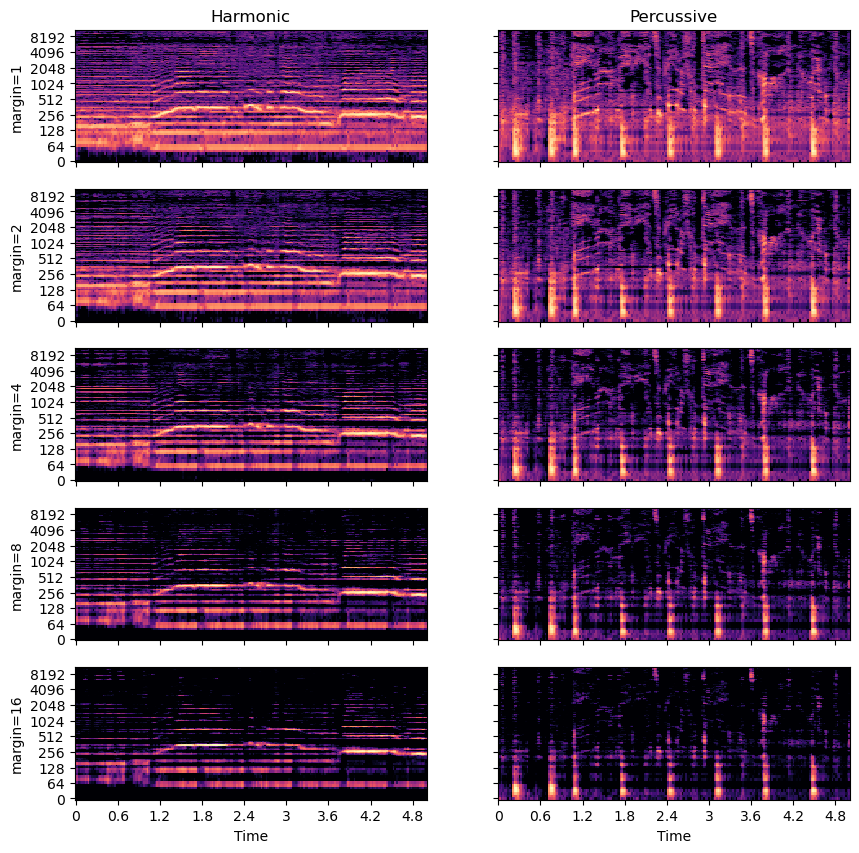

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(10, 10))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[0, 0])
ax[0, 0].set(title='Harmonic')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[0, 1])
ax[0, 1].set(title='Percussive')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic2), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[1, 0])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive2), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[1, 1])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic4), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[2, 0])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive4), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[2, 1])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic8), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[3, 0])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive8), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[3, 1])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic16), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[4, 0])

librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive16), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[4, 1])

for i in range(5):
    ax[i, 0].set(ylabel='margin={:d}'.format(2**i))
    ax[i, 0].label_outer()
    ax[i, 1].label_outer()

In the plots above, it looks like margins of 4 or greater are sufficient to
produce strictly harmonic and percussive components.

We can invert and play those components back just as before.
Again, starting with the harmonic component:



In [12]:
y_harmonic4 = librosa.istft(D_harmonic4, length=len(y))
Audio(data=y_harmonic4, rate=sr)

And the percussive component:



In [13]:
y_percussive4 = librosa.istft(D_percussive4, length=len(y))
Audio(data=y_percussive4, rate=sr)